In [ ]:
#load all libraries
from tensorflow.keras.optimizers import SGD
from google.colab import drive
from pydrive.drive import GoogleDrive
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import shutil
import random
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten
from keras.models import  Model
from math import ceil
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
from keras.callbacks import EarlyStopping, Callback
from keras.applications.densenet import DenseNet169, preprocess_input

#mount google drive and unzip folder containing images
#BEWARE file size is 9.8GiB and images will be stored locally
drive.mount('/content/gdrive')
!unzip gdrive/My\ Drive/archive.zip > /dev/null
print("Total Images: {}".format(len([name for name in os.listdir('ISIC_2019_Training_Input/ISIC_2019_Training_Input')])))

Mounted at /content/gdrive
Total Images: 25333


In [ ]:
#create three dataframes, each for melanoma, basal cell carcinoma, seborrheic keratosis
def OrganizeImages():
  df_gt = pd.read_csv ('ISIC_2019_Training_GroundTruth.csv')
  df_meta = pd.read_csv ('ISIC_2019_Training_Metadata.csv')

  df_mel = df_gt.loc[(df_gt['MEL'] == 1)]
  df_bcc = df_gt.loc[(df_gt['BCC'] == 1)]
  df_bkl = df_gt.loc[(df_gt['BKL'] == 1)]

  return df_mel, df_bcc, df_bkl

In [ ]:
#only extract images coresponding to melanoma, basal cell carcinoma, seborrheic keratosis and move them into corresponding folders
def ExtractImages(df, name):
  dir = name + "/" + name
  os.mkdir(name)
  os.mkdir(dir)

  for index, row in df.iterrows():
    image = "ISIC_2019_Training_Input/ISIC_2019_Training_Input/{}.jpg".format(row['image'])
    shutil.move(image, dir)

  print("Total " + name + " images: {}".format(len([name for name in os.listdir(dir)])))

In [ ]:
#splitting data into train, validation, testing and move them into corresponding folders
def SplitData(name, training, validation, test):
  dir = name + "/" + name
  length = len([name for name in os.listdir(dir)])
  train_size = round(length * training)
  validation_size = round(length * validation)
  test_size = round(length * test)

  #preventative; if already ran once, folders will likly already exists
  try:
    os.mkdir('train/' + name)
    os.mkdir('validation/' + name)
    os.mkdir('test/' + name)
  except OSError as e:
    print("Error: {}.\nContinuing...".format(e.strerror))

  #loop through each dir for skin lesion and move images to correspodning train, valid, test
  end_index = 0
  names = [name for name in os.listdir(dir)]
  for i in range(train_size):
    image = dir + "/{}".format(names[i])
    shutil.move(image, 'train/' + name)
    end_index = i
  
  for i in range(end_index + 1, end_index + validation_size):
    image = dir + "/{}".format(names[i])
    shutil.move(image, 'validation/' + name)
    end_index = i

  for i in range(end_index + 1, end_index + test_size):
    image = dir + "/{}".format(names[i])
    shutil.move(image, 'test/' + name)

  print_str = name + ":\n\tTrain Size: {}\n\tValidation Size: {}\n\tTest Size: {}\n"
  print(print_str.format(len([name for name in os.listdir('train/' + name)]), len([name for name in os.listdir('validation/' + name)]), len([name for name in os.listdir('test/' + name)])))

In [ ]:
#method to balance dataset
def ClassBalance(train):
  counter = Counter(train.classes)
  max_val = float(max(counter.values()))
  class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}

In [ ]:
#image augmentation to be done: using only zca_epsilon, rotation, flip
train_arg_params = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    zca_epsilon = 1e-06,
    rotation_range = 90,
    width_shift_range = [-30, 30],
    height_shift_range = [-30, 30],
    brightness_range = None,
    shear_range = 0.0,
    zoom_range = 0.0,
    channel_shift_range = 0.0,
    fill_mode = 'nearest',
    cval = 0.0,
    horizontal_flip = True,
    vertical_flip = True,
    rescale = None,
    preprocessing_function = preprocess_input,
    data_format = None,
    validation_split = 0.0,
    dtype = None
)

test_arg_params = ImageDataGenerator(preprocessing_function = preprocess_input)

In [ ]:
#method to show example of image augmention 
def ShowExampleArg(name, count):

  #if folder exits (already example images), delete and create new set
  try:
    os.mkdir(name + "/ExampleArg/")
    os.mkdir(name + "/ExampleArg/" + name)
  except OSError as e:
    print("Deleting dir {}".format(name + "/ExampleArg"))
    shutil.rmtree(name + "/ExampleArg/")
    print("Creating dir {}".format(name + "/ExampleArg/" + name))
    os.mkdir(name + "/ExampleArg/")
    os.mkdir(name + "/ExampleArg/" + name)

  dir = "train/" + name
  length = len([name for name in os.listdir(dir)])
  names = [name for name in os.listdir(dir)]

  #choosing random images everytime
  #find a random integer that won't cause out of index error
  rand_int = random.randint(0, length)
  while (rand_int + count > length):
    rand_int = random.randint(0, length)

  #moves example images to different folder
  for i in range(rand_int, rand_int + count):
    image = dir + "/{}".format(names[i])
    target = name + "/ExampleArg/" + name + "/" + str(names[i])
    shutil.copyfile(image, target)

  #start argumentation
  examples = train_arg_params.flow_from_directory(name + '/ExampleArg', target_size = inputSize[0:2])

  #display example
  sub_plots = list(range(1, (count * 4) + 1))
  fig = plt.figure(figsize=(50, 50))

  for img in range(0, count * 4):
    x,y = examples.next()
    image = x[0]
    sub = fig.add_subplot(8,8, sub_plots[img])
    sub.axis('off')
    sub.imshow(image)
  plt.show()

In [ ]:
#method to create data for train, valid, and test. 
#meant to apply augmention to specific sections
def CreateDataForModel():
  train = train_arg_params.flow_from_directory("train",
                                batch_size=6,
                                target_size = inputSize[0:2],
                                class_mode="categorical")

  validation = test_arg_params.flow_from_directory("validation",
                                  batch_size=6,
                                  target_size = inputSize[0:2],
                                  class_mode="categorical")

  test = test_arg_params.flow_from_directory("test",
                                  target_size = inputSize[0:2],
                                  class_mode="categorical")
  
  return train, validation, test

In [ ]:
#method to build the model
def BuildModel(train, lr, mom):
  densenet = DenseNet169(include_top = False, pooling = 'avg', weights = 'imagenet', input_shape = (224,224,3))
  x = densenet.output

  #change final layer to 3 becuase only 3 classes
  last = Dense(train.num_classes, activation='softmax', name = 'last')(x)
  model = Model(inputs = densenet.input, outputs = last)

  model = Model(inputs = densenet.input, outputs = last)
  optimizer = SGD(lr = lr, momentum = mom, nesterov = False)
  model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

  #option to show layers in model
  #print(model.summary())
  return model

In [ ]:
#plot ROC and AUC to analyze model performance
def PlotROC_AUC(y_test, y_pred, labels):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  plt.figure(figsize=(5, 5))

  #extract fpr and tpr
  for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  #graph 
  colors = ['r', 'g', 'b']
  for i, color in zip(range(len(labels)), colors):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5, label = '{} (AUC = {})'.format(labels[i], roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw = 1.5)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend()
  plt.show()

In [ ]:
#plot loss v accruacy
def PlotLossAcc(history):
  fig = plt.figure(figsize=(50, 50))
  sub = fig.add_subplot(8, 8, 1)
  sub.plot(history.history["loss"], label = "Train loss")
  sub.plot(history.history["val_loss"], label = "Val Loss")
  sub.title.set_text("Train Loss v Val Loss")
  sub.legend()

  sub2 = fig.add_subplot(8, 8, 2)
  sub2.plot(history.history["accuracy"], label = "Train Acc.")
  sub2.plot(history.history["val_accuracy"], label = "Val Acc.")
  sub2.title.set_text("Train Acc. v Val Acc.")
  sub2.legend()

In [ ]:
#method to test the model on testing dataset
def TestModel(test, model):
  x_test = []
  y_test = []
  for i in range(ceil(test.n/test.batch_size)):
    x_iter, y_iter = test.next()
    x_test.extend(x_iter)
    y_test.extend(y_iter)

  x_test = np.array(x_test) 
  y_test = np.array(y_test)

  y_pred = model.predict(x_test)
  vector = np.argmax(y_test, 1)

  return x_test, y_test, y_pred, vector

In [ ]:
#method to show example ground truth and prediction of random images
def ShowExampleTestPred(test, x_test, y_pred, vector, count):
  sub_plots = list(range(1, (count) + 1))
  fig = plt.figure(figsize=(50, 50))
  labels = list(test.class_indices.keys())

  #graph
  for i in range(0, count):
    random_image = np.random.randint(test.n)
    image = x_test[random_image]
    sub = fig.add_subplot(8, 8, sub_plots[i])
    sub.title.set_text('Ground truth = '+ labels[int(vector[random_image])] + ';  Prediction = ' + labels[np.argmax(y_pred[random_image])])
    sub.axis('off')
    sub.imshow(image)

  plt.show()

In [ ]:
#organize and extract melanoma, basal cell carcinoma, seborrheic keratosis into seperate folders 
df_mel, df_bcc, df_bkl = OrganizeImages()
ExtractImages(df_mel, 'MEL')
ExtractImages(df_bcc, 'BCC')
ExtractImages(df_bkl, 'BKL')

#split data into training, validatin, testing
training = 0.7
validation = 0.15
test = 0.15
inputSize= [224, 224, 3]

#make dir before splitting data
os.mkdir('train')
os.mkdir('validation')
os.mkdir('test')
SplitData('MEL', training, validation, test)
SplitData('BCC', training, validation, test)
SplitData('BKL', training, validation, test)

Total MEL images: 4522
Total BCC images: 3323
Total BKL images: 2624
MEL:
	Train Size: 3165
	Validation Size: 677
	Test Size: 677

BCC:
	Train Size: 2326
	Validation Size: 497
	Test Size: 497

BKL:
	Train Size: 1837
	Validation Size: 393
	Test Size: 393



Found 1 images belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


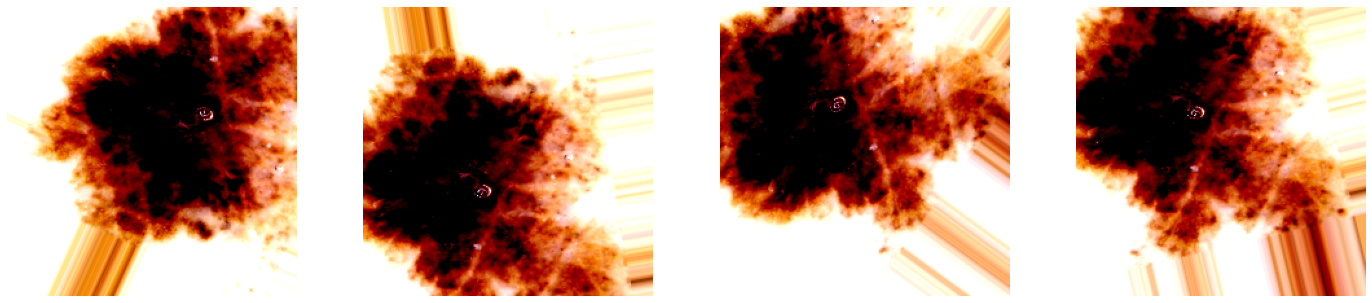

In [ ]:
#showing example augmetation
ShowExampleArg('MEL', 1)

In [ ]:
#create frames for the training, validation, and testing for each class
train, validation, test = CreateDataForModel()

Found 7328 images belonging to 3 classes.
Found 1567 images belonging to 3 classes.
Found 1567 images belonging to 3 classes.


In [ ]:
#SGD paramters
lr = 0.001
mom = 0.05

#obtain class balance weights, and compile model
weights = ClassBalance(train)
model = BuildModel(train, lr, mom)

51888128/51877672 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
#train model with added early stop to stop if val_loss does not increase over a patience of 5 steps
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(train, steps_per_epoch = ceil(train.n / 6), epochs = 50, shuffle = True,
                                    validation_data=validation, validation_steps = ceil(validation.n / 6),
                                    callbacks = [early_stop], verbose = 1, class_weight = weights)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
1222/1222 [==============================] - 313s 238ms/step - loss: 0.7997 - accuracy: 0.6382 - val_loss: 0.7254 - val_accuracy: 0.6847
Epoch 2/50
1222/1222 [==============================] - 259s 212ms/step - loss: 0.6655 - accuracy: 0.7200 - val_loss: 0.6259 - val_accuracy: 0.7479
Epoch 3/50
1222/1222 [==============================] - 257s 210ms/step - loss: 0.6148 - accuracy: 0.7471 - val_loss: 0.5525 - val_accuracy: 0.7696
Epoch 4/50
1222/1222 [==============================] - 261s 213ms/step - loss: 0.5765 - accuracy: 0.7666 - val_loss: 0.5510 - val_accuracy: 0.7760
Epoch 5/50
1222/1222 [==============================] - 258s 211ms/step - loss: 0.5461 - accuracy: 0.7807 - val_loss: 0.5315 - val_accuracy: 0.7843
Epoch 6/50
1222/1222 [==============================] - 260s 213ms/step - loss: 0.5230 - accuracy: 0.7903 - val_loss: 0.5273 - val_accuracy: 0.7773
Epoch 7/50
1222/1222 [==============================] - 258s 211ms/step - loss: 0.5119 - accuracy: 0.7913 - val_

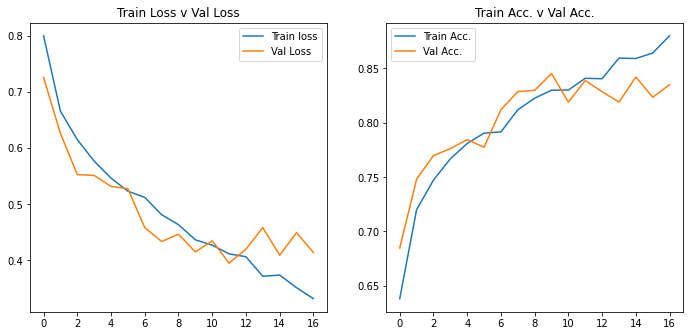

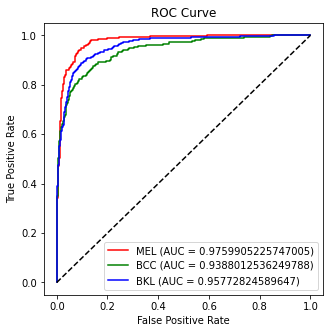


Accuracy: 0.837



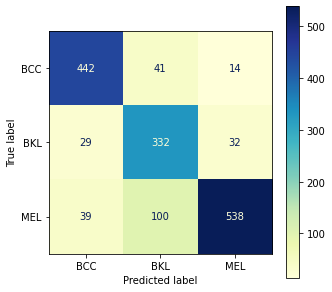

In [ ]:
#get prediction resuls from trained model
x_test, y_test, y_pred, vector = TestModel(test, model)

#plot to analyze models performance
PlotLossAcc(history)
PlotROC_AUC(y_test, y_pred, ['MEL', 'BCC', 'BKL'])

#Obtain accuracy score of model
test_acc = accuracy_score(np.argmax(y_test, axis = 1), np.argmax(y_pred, axis = 1))
print('\nAccuracy: {}\n'.format(round(test_acc, 3)))

#get confusion matrix from model
c_matrix = confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(y_pred, axis = 1))
disp = ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels = train.class_indices.keys())
disp.plot(cmap ='YlGnBu')
disp.figure_.set_size_inches(5, 5)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


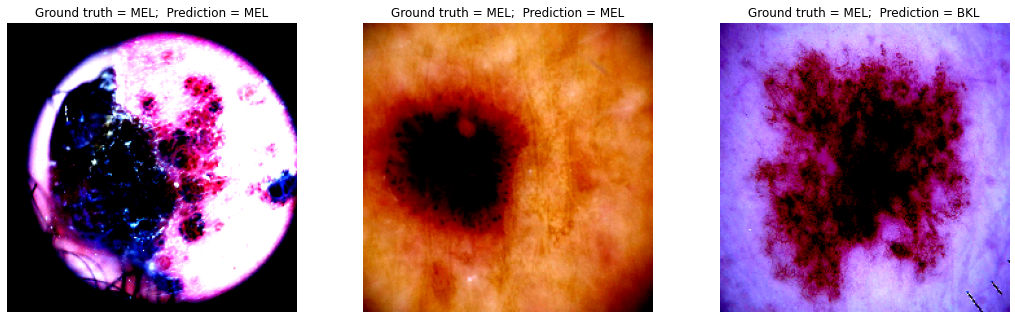

In [ ]:
#show randome images with ground truth and predicted class
ShowExampleTestPred(test, x_test, y_pred, vector, 3)